# 0. Introduction

This notebook replicates the experimental results in our paper for Bayesian non-parametric inference of Lévy measures in the Lévy SSM using the simulation data. Our main focus here is to replicate the experimental results in our paper, but we demonstrate also how to generate your own observations, and it should be straightforward then for you to feed your own data to the algorithm.

## Contents
1. Loading Data in the Paper or Generate New Simulation Data
2. MCMC Inference for the Lévy Measures (Paper Data)
3. Posterior Analysis of the Samples
4. Notes on Practical Application

[^1]: B. Z. Lin and S. Godsill. Bayesian Non-Parametric Inference for Lévy Measures in State-Space Models. (arXiv:2505.22587), May 2025. arXiv:2505.22587 [stat]


## Modules and Random Seed

We import the necessary modules and also fix the random seed in the following block. Feel free to change the seed. To get more random behaviour, just run the sub block for more times.



In [1]:
import os
import random
import numpy as np
#Fixing the random seed
SEED = 42               # ← change once and everything follows
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
import matplotlib.pyplot as plt
import seaborn as sns
from Levy_Generators import *
from tqdm import tqdm
from Common_Tools import *
from Levy_State_Space import *
from posteriors import*
from mcmc_sampler import*
from ground_truths import*


# 1. Loading Data in the Paper or Generate New Simulation Data

## Generate Data (Same Simulation in the Preliminaries Notebook)

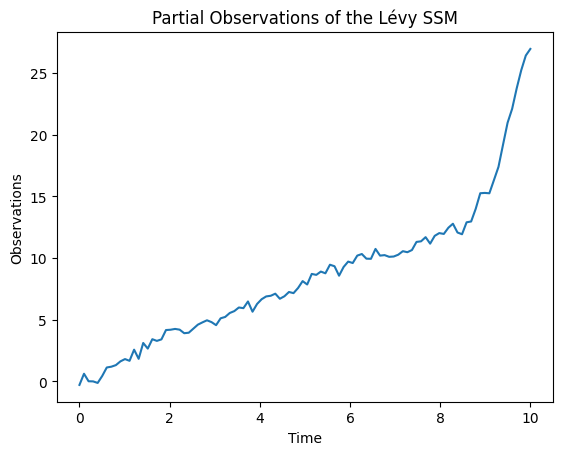

In [2]:
#Define the simulation rates for the truncated series simulation
sim_rate = 50 #The parameter c in the latex notes

#Define the time axis
T = 10.0
time_axis = np.linspace(0,T,int(T)*10)

#TS parameter definition and process generation
beta=0.2
alpha = 0.2
C=0.5
sub_jump_sizes,jump_times = tempered_stable_process_jumps((beta,alpha,C),T,sim_rate)

#NVM process generation: Define the Brownian motion and then generate the series representation
muw = 1.0
sigmaw = 1.0
nvm_jump_sizes = nvm_process_jumps(sub_jump_sizes,muw,sigmaw)

#The generalized shot noise representation for the Levy SSM
theta = -1.0
langevin_path = langevin_hidden_response(nvm_jump_sizes,jump_times,theta,time_axis) #(2,N) process path
true_x = langevin_path[0,:] #(N,)
true_x_dot = langevin_path[1,:]#(N,)

#Define the partial observation noise level in standard deviation
observation_noise_level = 0.3
full_observations = langevin_observations(langevin_path,(observation_noise_level**2)*np.identity(2))
observations = np.zeros((1,np.shape(full_observations)[1]))
observations[0,:] = full_observations[0,:]

#Show the observations
plt.figure()
plt.plot(time_axis,observations[0,:])
plt.xlabel("Time")
plt.ylabel("Observations")
plt.title("Partial Observations of the Lévy SSM")
plt.show()

## Load the Data in the Paper

The npz file contains also the ground truth values for the inference targets (unknown), and the parameters treated as known in the algorithm.

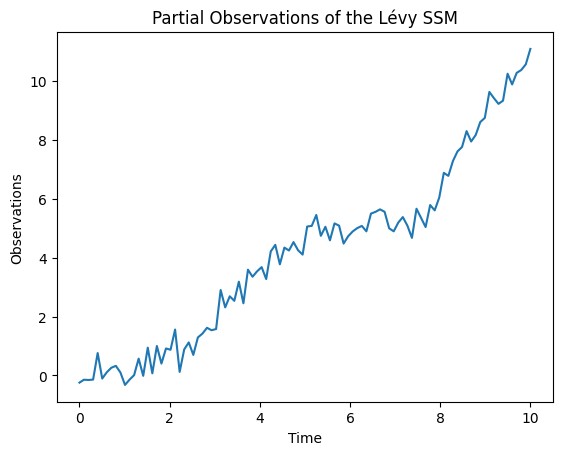

In [3]:
"""1. Load the Data"""
data = np.load("Simulated_Experiment_Data.npz")
observations = data["observations"]
#Show the observations
plt.figure()
plt.plot(time_axis,observations[0,:])
plt.xlabel("Time")
plt.ylabel("Observations")
plt.title("Partial Observations of the Lévy SSM")
plt.show()




"""2. Load the known Parameters"""
sim_rate = data["sim_rate"]
observation_noise_level = data["observation_noise_level"]
kv = data["kv"] #The normalized observation noise level
T = data["T"]
time_axis = data["time_axis"]





"""3. Load the ground truth values and other information (unknown to the algorithm)"""
#TS Levy Measure Grount Truth Parameters
beta = data["beta"]
alpha = data["alpha"]
C = data["C"]
#NVM Grount Truth Parameters (The Brownian parameters)
muw = data["muw"]
sigmaw = data["sigmaw"]
#The Levy SSM Parameters
theta = data["theta"]
#The actual latent states
sub_jump_sizes = data["sub_jump_sizes"]
jump_times = data["jump_times"]
original_path = data["original_path"]
nvm_jump_sizes = data["nvm_jump_sizes"]
langevin_path = data["langevin_path"]
true_x = data["true_x"]
true_x_dot = data["true_x_dot"]
full_observations = data["full_observations"]



# 2. MCMC Inference for the Lévy Measures (Paper Data)

## 2.1 Algorithm Initialization
In this section, we initialize the algorithm using the primary approach mentioned in our paper.

Note that although we save the interface to DP base measure hyper-parameter sampling using a Gaussian random walk (GRW) approach, we have set the step sizes to 0, effectively freezing the inference. This is because as mentioned in the paper, we have found it only posing additional challenges to mixing, and no obvious benefit has been found. Feel free to change the parameters and set-up in this section to see the down sizes.

In [4]:
"""1. Define the MCMC Algorithm Parameters"""
#Iterations and burn-in
burn_in = 20000
num_iter = 120000  
#Overlapping Block Definition
block_width = 20
overlapping_width = 10

"""2. Levy Measure Prior"""
#Gamma Prior (Shape-Rate Convention)
rate_alpha_prior = 2 
rate_beta_prior = 1
#DP Prior (Finite DP)
dir_K = 1000
alphaw = 0.0001
betaw = 0.0001
#DP Concentration Parameter prior
initial_dir_alpha = 10.0
dir_alpha_a = 1.0
dir_alpha_b = 100.0
#DP Base Measure Parameter Prior and the GRW Definition (Change this section if you want to see the downsides.)
initial_base_gamma_a = 1.0
initial_base_gamma_b=1.0
base_gamma_a_mean = initial_base_gamma_a
base_gamma_a_std = 1000.0
base_gamma_b_mean = initial_base_gamma_b
base_gamma_b_std = 1000.0
base_gamma_a_step_size = 0.0
base_gamma_b_step_size = 0.0

"""3. System Parameter Prior and GRW Definition"""
theta_prior = theta * 1.0
theta_step_size = observation_noise_level * 0.7 #This is the factor applied to the standard deviation. Square it to apply it to the variance.


"""Jump Series Prior Generated from the Truncated Series Generators Mentioned Before"""
#Make a guess of the correct parameters. Feel free to change the factors to see the differences, but do increase burn-in time.
#This is a fair guess since we only need 3 parameters for the high dimensional jump series data.
beta_guess = 1*beta
alpha_guess = 1*alpha
C_guess = 1*C
initial_jump_sizes,initial_jump_times = tempered_stable_process_jumps((beta_guess,alpha_guess,C_guess),T,sim_rate)
#Group the jump series according to the time indices
grouped_jump_sizes,grouped_jump_times = group_jumps(initial_jump_sizes,initial_jump_times,time_axis)


## 2.2 Run the Algorithm and Save the Results

Just feed in the parameters and then click run.

In [5]:
(
    sample_measures,
    sample_rates,
    sample_paths,
    sample_thetas,
    overall_theta_acceptance_probability,
    sample_x_means,
    sample_x_covariances,
    sample_alphaw_posts,
    sample_betaw_posts,
    dir_alphas,
    base_gamma_as,
    base_gamma_bs,
) = langevin_lm_theta_inference_all_DP_alpha_inferred_Gamma_base_Gaussian_update(
    num_iter,
    block_width,
    overlapping_width,
    observations,
    time_axis,
    initial_jump_sizes,
    initial_jump_times,
    kv,
    rate_alpha_prior,
    rate_beta_prior,
    dir_K,
    dir_alpha_a,
    dir_alpha_b,
    base_gamma_a_mean,
    base_gamma_a_std,
    base_gamma_b_mean,
    base_gamma_b_std,
    alphaw,
    betaw,
    theta_prior,
    theta_step_size,
    base_gamma_a_step_size,
    base_gamma_b_step_size,
    dir_alpha=initial_dir_alpha,
    base_gamma_a=initial_base_gamma_a,
    base_gamma_b=initial_base_gamma_b,
)

Langevin System Inference Progress:: 100%|██████████| 120000/120000 [1:32:11<00:00, 21.69it/s]  


In [6]:
#Discard the burn-in
sample_measures = sample_measures[burn_in:]
sample_rates = sample_rates[burn_in:]
sample_paths = sample_paths[burn_in:]
sample_thetas = sample_thetas[burn_in:]
sample_x_means = sample_x_means[burn_in:]
sample_x_covariances = sample_x_covariances[burn_in:]
sample_alphaw_posts = sample_alphaw_posts[burn_in:]
sample_betaw_posts = sample_betaw_posts[burn_in:]

#Save the MCMC Sampler Results in the buffer file.
np.savez(
    "buffer.npz",
    sample_measures=sample_measures,
    sample_rates=sample_rates,
    sample_paths=sample_paths,
    sample_thetas=sample_thetas,
    sample_x_means=sample_x_means,
    sample_x_covariances=sample_x_covariances,
    sample_alphaw_posts=sample_alphaw_posts,
    sample_betaw_posts=sample_betaw_posts,
    overall_theta_acceptance_probability = overall_theta_acceptance_probability
)

# 3. Posterior Analysis of the Samples

## 3.1 Basic Gathering and Packing of the Posterior Samples

Warning: The following code has quite a large room for improvement.

In [7]:
overall_rates_list = []
overall_positions_list = []
NVM_conditional_lower_tails = []
NVM_conditional_upper_tails = []
overall_NVM_discrete_rates = []
overall_NVM_discrete_positions = []
epsilon = 1e-5 #The minimum valku for the x axis of the upper tail function. This cannot go to 0 for stability reason
x_axis = np.logspace(np.log10(epsilon),np.log10(5),1000) #Change the resolution parameter here to change the bin density
# Combine the negative and positive parts to form the nvm_axis
nvm_positive_axis = np.logspace(np.log10(epsilon),np.log10(5),100)
nvm_negative_axis =np.logspace(np.log10(epsilon),np.log10(3),100)
nvm_axis = np.concatenate([-nvm_negative_axis[::-1], nvm_positive_axis])
sample_upper_tail_measures = []


#Averaging and combining the samples
for i in tqdm(range(len(sample_measures)),desc="Posterior Analysis"):#Iterating over the samples in each iteration
    sample_rate = sample_rates[i]
    sample_measure = sample_measures[i]  # 2 x K
    sample_measure[0, :] = sample_measure[0, :] * sample_rate  # K-dimensional array. Combining the rate and jump size distributioin into the Levy density
    sample_measures[i] = sample_measure
    rates = sample_measure[0, :]
    positions = sample_measure[1, :]
    #Compute and store the upper tail measure function values on the x axis defined
    sample_upper_tail_measure = DP_upper_tail_projection(positions,rates,x_axis)
    sample_upper_tail_measures.append(sample_upper_tail_measure)
    # Collect arrays in lists
    overall_rates_list.append(rates)
    overall_positions_list.append(positions)
    #Posterior Analysis of the samples
    alphaw_post = sample_alphaw_posts[i]
    betaw_post = sample_betaw_posts[i]
    x_mean_sample_series = sample_x_means[i] #The mean series inferred by the Kalman filter 
    x_covariance_sample_series = sample_x_covariances[i]#The covariance series inferred by the Kalman filter
    muw_posterior_mean = x_mean_sample_series[-1,-1,0]
    muw_posterior_variance = x_covariance_sample_series[-1,-1,-1]#Note that this is the marginalized covariance wrt \sigma_w^2 but not the exact covariance
    lower_tail_conditional,upper_tail_conditional = NVM_measure_tail_functions(rates, positions,nvm_axis, muw_posterior_mean,muw_posterior_variance, alphaw_post,betaw_post)
    
    #Storing the inference results for the densities and/or the tails
    NVM_conditional_lower_tails.append(lower_tail_conditional)
    NVM_conditional_upper_tails.append(upper_tail_conditional)

Posterior Analysis: 100%|██████████| 100001/100001 [18:13<00:00, 91.41it/s]


## 3.2 Visualizing the Mixing Performance

ACF Computation Progress: 100%|██████████| 1001/1001 [03:30<00:00,  4.76it/s]


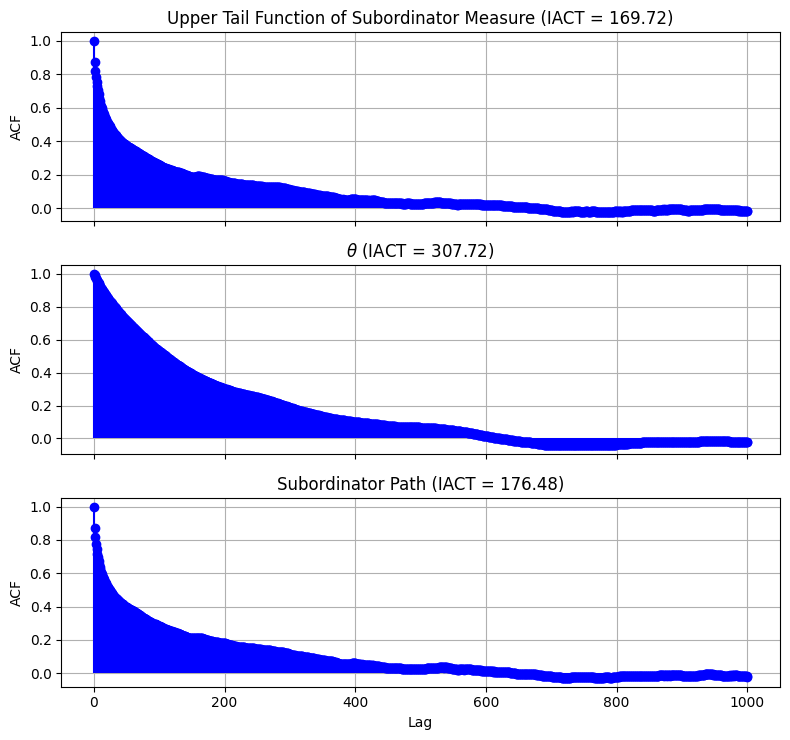

In [8]:
max_lag = 1000
theta_acf,theta_iact = compute_acf_and_iact(sample_thetas,max_lag)
sample_paths = np.array(sample_paths)[:,0,:] #This converts the length N list with each element being (T,) array into an (N,T) matrix compatible with the ACF and IACT function
sample_path_acf,sample_path_iact = compute_functional_acf_and_act(sample_paths,time_axis, max_lag)
sample_upper_tail_measure_matrix = np.array(sample_upper_tail_measures)
upper_tail_measure_acf,upper_tail_measure_iact = compute_functional_acf_and_act(sample_upper_tail_measure_matrix,x_axis, max_lag)
acf_arrays = [upper_tail_measure_acf,theta_acf, sample_path_acf]
iact_values = [upper_tail_measure_iact,theta_iact, sample_path_iact]
labels = ["Upper Tail Function of Subordinator Measure",f"$\\theta$", "Subordinator Path"]
max_lag = len(theta_acf) - 1
plot_acf_arrays(acf_arrays, iact_values, labels, max_lag)


## 3.3 Visualizing the Hidden State Inference Results.
### 3 States: Integrated Process, Stationary Process, and the Drift/Skewness Parameter (from the Augmentation Trick and will be Discussed again)

<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
/var/folders/my/1lmytx1n493d41xbk6p_vgkw0000gn/T/ipykernel_94085/3216963565.py:5: SyntaxWarning: invalid escape sequence '\m'
  states_names = ["x",f"$dx/dt$",f"\mu_w"]


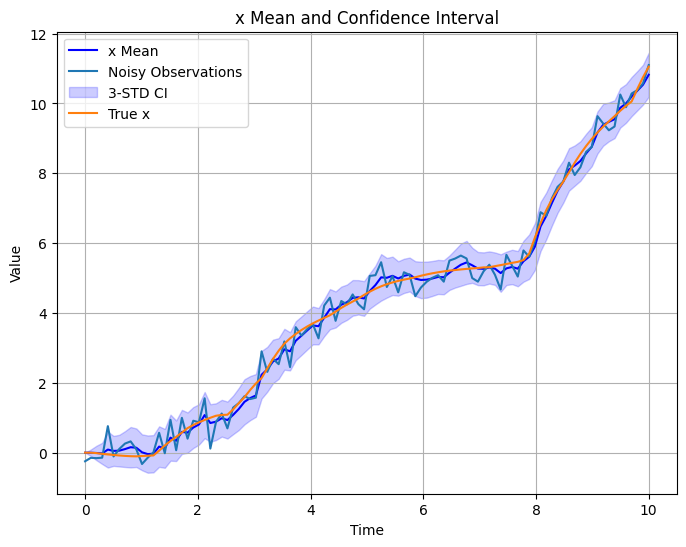

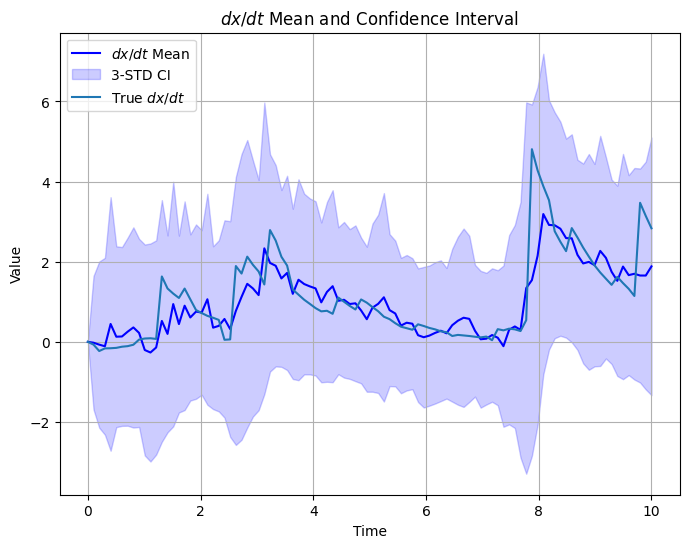

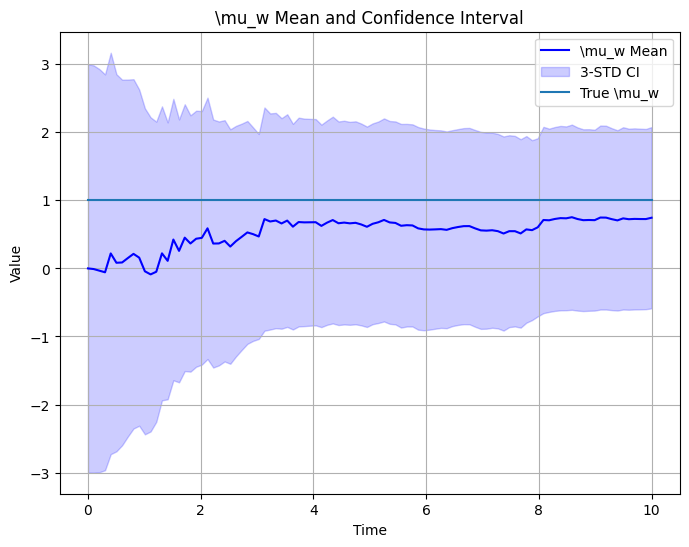

In [9]:
#Plotting the hidden state inference
average_x_means,average_x_covariances = Gaussian_average(sample_x_means,sample_x_covariances)
sigmaw2_mean,sigmaw2_variance = IG_average(sample_alphaw_posts,sample_betaw_posts)
std_devs = np.sqrt(np.diagonal(average_x_covariances, axis1=1, axis2=2))  # Shape: (100, 3)
states_names = ["x",f"$dx/dt$",f"\mu_w"]
true_state_values = [true_x,true_x_dot,muw*np.ones(len(time_axis))]
for state_idx in range(3):  # Loop over the 3 states
    plt.figure(figsize=(8, 6))
    state_name = states_names[state_idx]
    true_values = true_state_values[state_idx]
    means = average_x_means[:, state_idx, 0]  # Mean values for the current state

    stds = std_devs[:, state_idx]  # Standard deviations for the current state

    # Plot the mean values
    plt.plot(time_axis, means, label=f'{state_name} Mean', color='blue')

    if state_idx == 0:
        plt.plot(time_axis,observations[0,:],label = "Noisy Observations")

    # Plot the confidence intervals (3 standard deviations)
    plt.fill_between(
        time_axis,
        means - 3 * stds,
        means + 3 * stds,
        color='blue',
        alpha=0.2,
        label='3-STD CI'
    )
    plt.plot(time_axis,true_values,label=f"True {state_name}")
    plt.title(f'{state_name} Mean and Confidence Interval')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.grid()
    plt.show()

## 3.4 Visualizing the System Parameter Inference Results

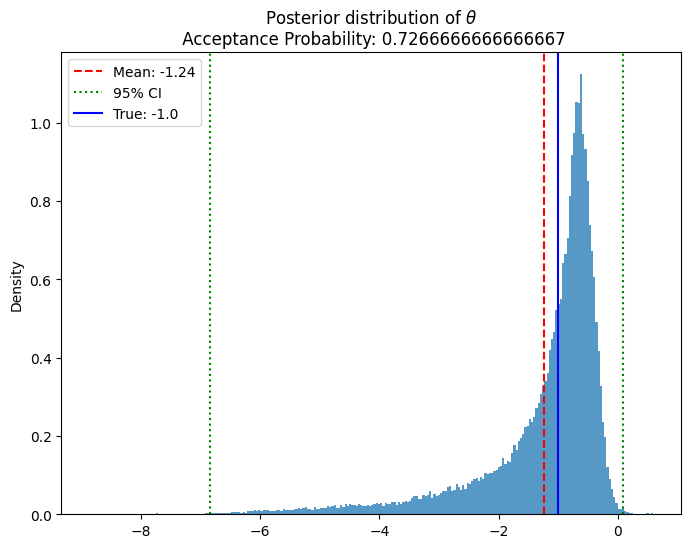

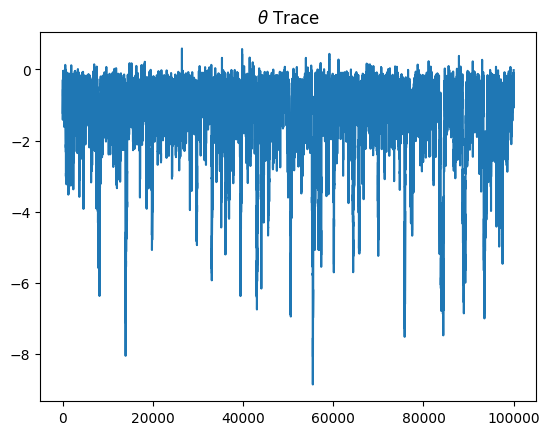

In [10]:
# Theta Sample Plot
plt.figure(figsize=(8, 6))  # Adjust figure size as needed
sns.histplot(sample_thetas, kde=False, stat="density", linewidth=0) #Turn on and off the kernel density here. Prof Godsill doesn't like it so it is turned off here
plt.axvline(np.mean(sample_thetas), color='r', linestyle='--', label=f'Mean: {np.mean(sample_thetas):.2f}')
plt.axvline(np.percentile(sample_thetas, 0.15), color='g', linestyle=':', label='95% CI')
plt.axvline(np.percentile(sample_thetas, 99.85), color='g', linestyle=':')
plt.axvline(theta, color='blue', linestyle='-', label=f'True: {theta}')
plt.title(f'Posterior distribution of $\\theta$ \n Acceptance Probability: {overall_theta_acceptance_probability}')
plt.legend()
plt.show()
#Theta Trace Plot
plt.figure()
plt.plot(sample_thetas)
plt.title(f"$\\theta$ Trace")
plt.show()

## 3.5 Visualizing the Lévy Measures Inference Results

In [11]:
# Concatenate arrays outside of the loop for better performance
rates = np.concatenate(overall_rates_list)
positions = np.concatenate(overall_positions_list)
#Divide the concatenate rates by the total number of samples to find the marginalized posterior DP measure mean
mean_weights = rates/(num_iter+1) # The mean_weights and positions together form the posterior mean DP measure.


#Infer the NVM Density/tails, additional average needed to marginalize out the condition on the subordinator series
#NVM_densities_array = np.vstack(NVM_conditional_densities)  # Shape: (num_densities, len(x_axis))
NVM_upper_tail_array = np.vstack(NVM_conditional_upper_tails)
NVM_lower_tail_array = np.vstack(NVM_conditional_lower_tails)
    # Compute the average density or tail
#NVM_density_inferred= np.mean(NVM_densities_array, axis=0)  # Shape: (len(x_axis),)
#Quantile Computation for the NVM Tails
lower_percentage = 0.15
upper_percentage = 99.85
nvm_upper_tail_lower_quantile = np.percentile(NVM_upper_tail_array, lower_percentage, axis=0)
nvm_upper_tail_upper_quantile = np.percentile(NVM_upper_tail_array, upper_percentage, axis=0)
nvm_lower_tail_lower_quantile = np.percentile(NVM_lower_tail_array, lower_percentage, axis=0)
nvm_lower_tail_upper_quantile = np.percentile(NVM_lower_tail_array, upper_percentage, axis=0)

NVM_upper_tail_inferred = np.mean(NVM_upper_tail_array,axis=0)
NVM_lower_tail_inferred = np.mean(NVM_lower_tail_array,axis=0)
#NVM ground truth tails generation
gt_sub_jump_sizes,gt_jump_times = tempered_stable_process_jumps((beta,alpha,C),T*5000,sim_rate)#Generate a bunch of jump sizes and times for computing the ground truth
NVM_lower_tail_ground_truth,NVM_upper_tail_ground_truth = NVM_ground_truth_tail_functions(nvm_axis,gt_sub_jump_sizes[0,:],muw,sigmaw,alpha,beta,C,epsilon*1e-2)
#Plotting Sessions
#Plotting the subordinator upper tail functions
#Compute the upper tail measure for the DP posterior mean measure and also the ground truth
posterior_mean_upper_tail_values = DP_upper_tail_projection(positions,mean_weights,x_axis)
ground_truth_upper_tail_values = upper_tail_ts_measure(alpha, beta, C,x_axis)
#Compute the quantiles given the x_axis

    # Stack the samples into a 2D array for easier quantile computation
ts_sample_array = np.vstack(sample_upper_tail_measures)

# Compute the quantiles (e.g., 2.5% and 97.5% for 95% CI)
ts_lower_quantile = np.percentile(ts_sample_array, lower_percentage, axis=0)
ts_upper_quantile = np.percentile(ts_sample_array, upper_percentage, axis=0)
negative_axis = nvm_axis[nvm_axis < 0]
positive_axis = nvm_axis[nvm_axis > 0]

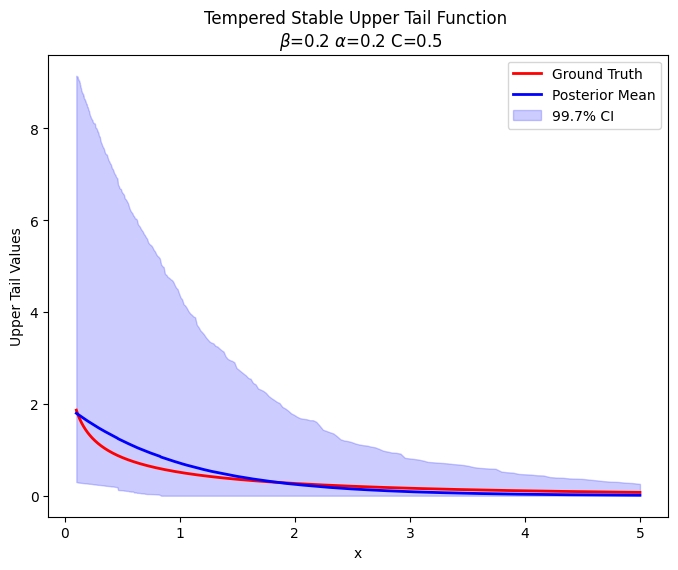

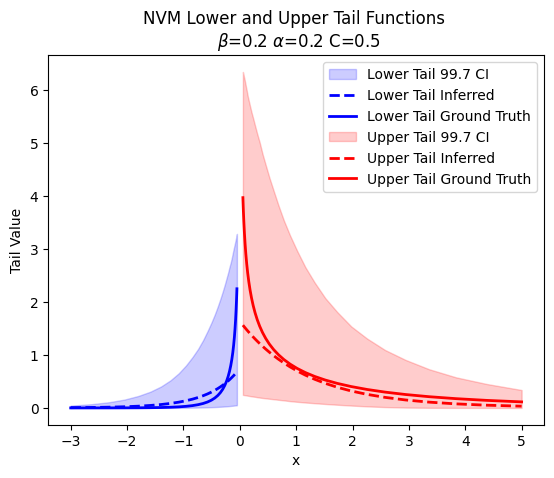

(100001, 100, 3, 1)
(100001, 100, 3, 3)
0.7448380317454055
(100001,)
(100001,)


In [ ]:
original_x_axis = x_axis
original_ground_truth_upper_tail_values = ground_truth_upper_tail_values
original_posterior_mean_upper_tail_values = posterior_mean_upper_tail_values
original_ts_lower_quantile = ts_lower_quantile
original_ts_upper_quantile = ts_upper_quantile


truncation_threshold = 0.1
mask = x_axis >= truncation_threshold
x_axis = original_x_axis[mask]
ground_truth_upper_tail_values = original_ground_truth_upper_tail_values[mask]
posterior_mean_upper_tail_values = original_posterior_mean_upper_tail_values[mask]
ts_lower_quantile = original_ts_lower_quantile[mask]
ts_upper_quantile = original_ts_upper_quantile[mask]
plt.figure(figsize=(8, 6))
plt.plot(x_axis, ground_truth_upper_tail_values, label="Ground Truth", color="red", linewidth=2)
plt.plot(x_axis, posterior_mean_upper_tail_values, label="Posterior Mean", color="blue", linewidth=2)
plt.fill_between(
    x_axis, ts_lower_quantile, ts_upper_quantile, color="blue", alpha=0.2, label=f"{round(upper_percentage-lower_percentage,4)}% CI"
)
plt.xlabel("x")
plt.ylabel("Upper Tail Values")
plt.title(f"Tempered Stable Upper Tail Function \n $\\beta$={beta} $\\alpha$={alpha} C={C}")
plt.legend()
plt.show()


original_negative_axis = negative_axis
original_nvm_lower_tail_lower_quantile = nvm_lower_tail_lower_quantile
original_nvm_lower_tail_upper_quantile = nvm_lower_tail_upper_quantile
original_NVM_lower_tail_inferred = NVM_lower_tail_inferred
original_NVM_lower_tail_ground_truth = NVM_lower_tail_ground_truth

original_positive_axis = positive_axis
original_nvm_upper_tail_lower_quantile = nvm_upper_tail_lower_quantile
original_nvm_upper_tail_upper_quantile = nvm_upper_tail_upper_quantile
original_NVM_upper_tail_inferred = NVM_upper_tail_inferred
original_NVM_upper_tail_ground_truth = NVM_upper_tail_ground_truth



truncation_threshold = 0.05
negative_axis = nvm_axis[nvm_axis < -0]
positive_axis = nvm_axis[nvm_axis > 0]
negative_axis_mask = negative_axis<-truncation_threshold
positive_axis_mask = positive_axis>truncation_threshold

negative_axis = original_negative_axis[negative_axis_mask]
nvm_lower_tail_lower_quantile = original_nvm_lower_tail_lower_quantile[negative_axis_mask]
nvm_lower_tail_upper_quantile = original_nvm_lower_tail_upper_quantile[negative_axis_mask]
NVM_lower_tail_inferred =  original_NVM_lower_tail_inferred[negative_axis_mask]
NVM_lower_tail_ground_truth = original_NVM_lower_tail_ground_truth[negative_axis_mask]


positive_axis = original_positive_axis[positive_axis_mask]
nvm_upper_tail_lower_quantile = original_nvm_upper_tail_lower_quantile[positive_axis_mask]
nvm_upper_tail_upper_quantile = original_nvm_upper_tail_upper_quantile[positive_axis_mask]
NVM_upper_tail_inferred = original_NVM_upper_tail_inferred[positive_axis_mask]
NVM_upper_tail_ground_truth = original_NVM_upper_tail_ground_truth[positive_axis_mask]


# Plot lower tail
plt.fill_between(
    negative_axis, 
    nvm_lower_tail_lower_quantile, 
    nvm_lower_tail_upper_quantile, 
    color="blue", alpha=0.2, label=f"Lower Tail {round(upper_percentage-lower_percentage,4)} CI"
)
plt.plot(
    negative_axis, 
    NVM_lower_tail_inferred, 
    color="blue", linestyle="--", linewidth=2, label="Lower Tail Inferred"
)
plt.plot(
    negative_axis, 
    NVM_lower_tail_ground_truth, 
    color="blue", linewidth=2, label="Lower Tail Ground Truth"
)

# Plot upper tail
plt.fill_between(
    positive_axis, 
    nvm_upper_tail_lower_quantile, 
    nvm_upper_tail_upper_quantile, 
    color="red", alpha=0.2, label=f"Upper Tail {round(upper_percentage-lower_percentage,4)} CI"
)
plt.plot(
    positive_axis, 
    NVM_upper_tail_inferred, 
    color="red", linestyle="--", linewidth=2, label="Upper Tail Inferred"
)
plt.plot(
    positive_axis, 
    NVM_upper_tail_ground_truth, 
    color="red", linewidth=2, label="Upper Tail Ground Truth"
)
plt.title(f"NVM Lower and Upper Tail Functions \n $\\beta$={beta} $\\alpha$={alpha} C={C}")
plt.xlabel("x")
plt.ylabel("Tail Value")
plt.legend()
plt.show()


sample_x_means = np.array(sample_x_means)
sample_x_covariances = np.array(sample_x_covariances)
sample_muw_means = sample_x_means[:,-1,-1,-1]
sample_muw_covariances = sample_x_covariances[:,-1,-1,-1]


## 3.6 Visualizing the NVM Process Parameters (Brownian Parameters) Inference Results

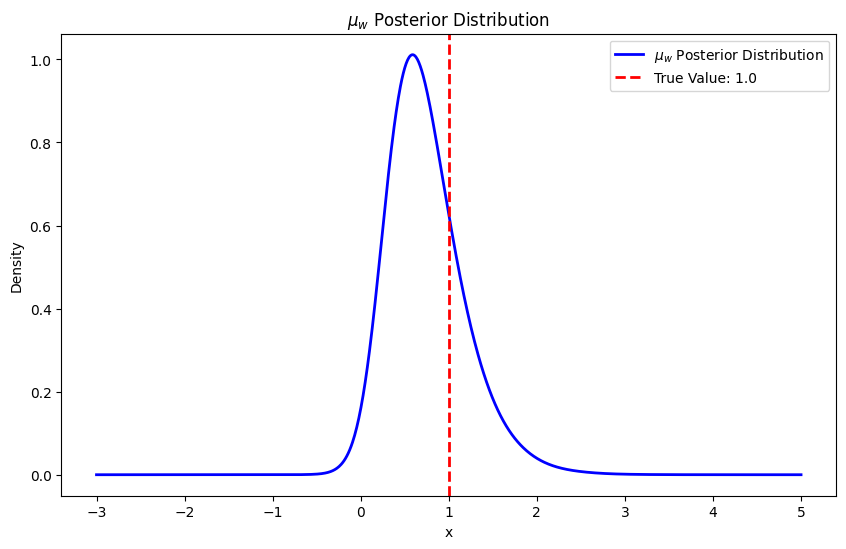

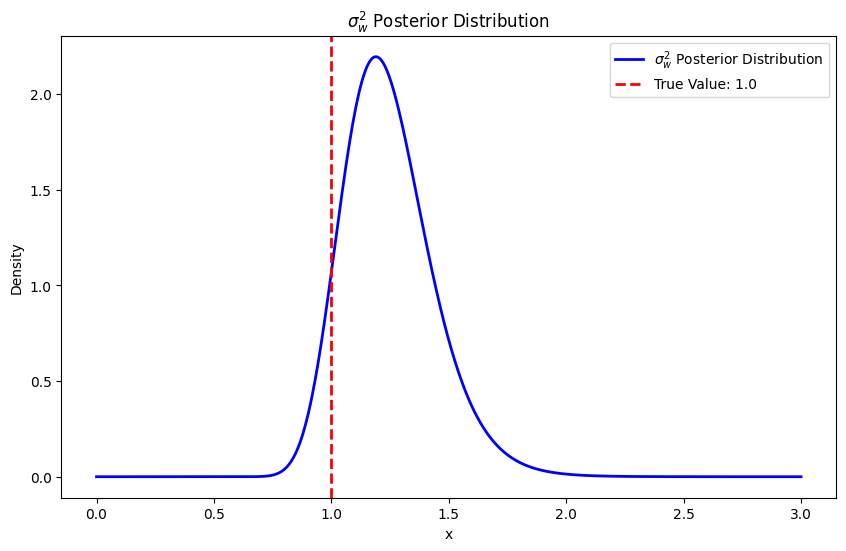

In [13]:
# Define the range for plotting
x = np.linspace(-3, 5, 1000)
weights = np.ones(len(sample_muw_covariances)) / len(sample_muw_covariances)
plot_mixture_of_gaussians(sample_muw_means,sample_muw_covariances,weights,x,muw,f"$\\mu_w$ Posterior Distribution")

# Define the range for plotting
x = np.linspace(0.0, 3, 1000)
weights = np.ones(len(sample_alphaw_posts)) / len(sample_alphaw_posts)
plot_mixture_of_inverse_gamma(sample_alphaw_posts,sample_betaw_posts,weights,x,sigmaw**2,f"$\\sigma_w^2$ Posterior Distribution")

## 3.7 Visualizing the DP Hyper-parameter Inference Results

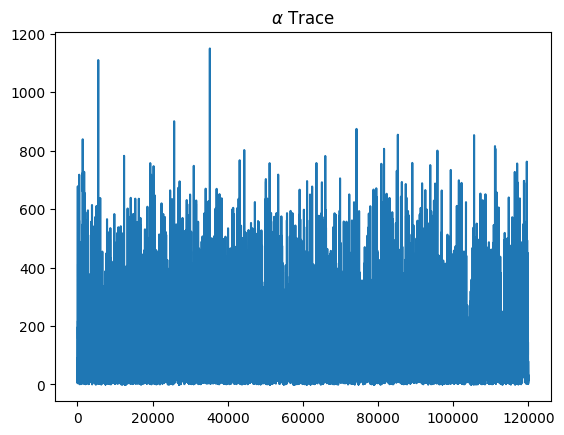

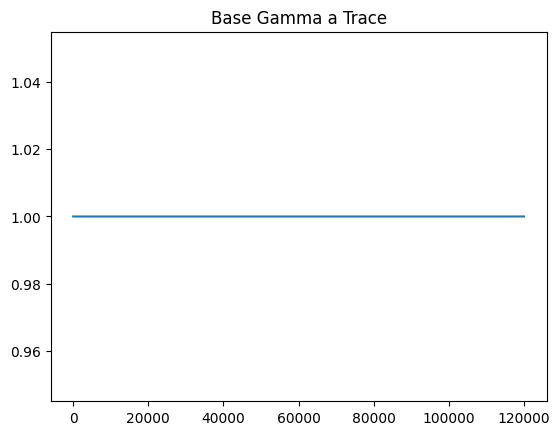

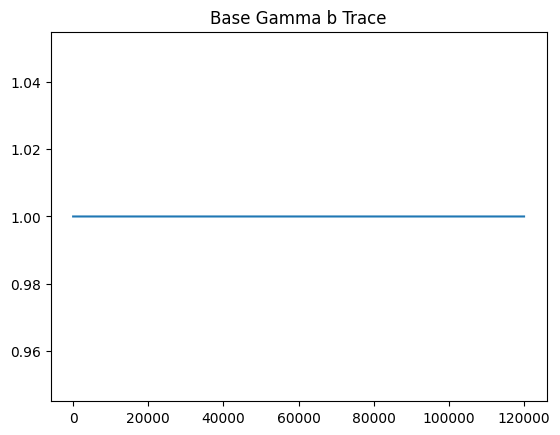

In [14]:
plt.figure()
plt.plot(dir_alphas)
plt.title(f"$\\alpha$ Trace")
plt.show()

plt.figure()
plt.plot(base_gamma_as)
plt.title(f"Base Gamma a Trace")
plt.show()

plt.figure()
plt.plot(base_gamma_bs)
plt.title(f"Base Gamma b Trace")
plt.show()

# 4. Notes on Practical Application

For practical usage of the results, we refer to the Rao-Blackwellized particle filter approach in [^1]. It is simple to adapt their approach to our case by changing the proposal distribution. There is only 1 potential problem about the dimension of the posterior Lévy measure inferred, which is an average of many discrete sample measures. In this section, we show that it is actually easy to solve the problem by making use of the clustering or discrete nature of the completely random measure. We apply a simple clustering algorithm to show that considerable reduction in the dimension can be achieved with no distinguishiable difference from the original measure.

[^1]: S. J. Godsill, M. Riabiz, and I. Kontoyiannis. The Lévy State Space Model. In 2019 53rd Asilomar Conference on Signals, Systems, and Computers, pages 487–494, 2019.


Mean Measure Computation Progress: 100%|██████████| 100001/100001 [00:03<00:00, 25634.26it/s]


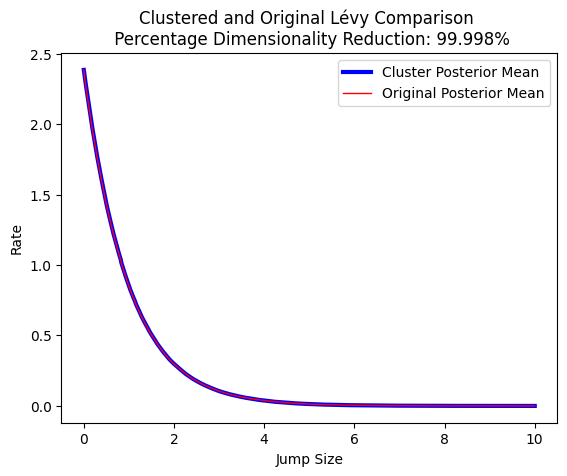

In [15]:
sample_Levy_measures = np.array(sample_measures.copy())
mean_weights = []
mean_locations = []

for i in tqdm(range(np.shape(sample_measures)[0]),desc = "Mean Measure Computation Progress"): #Iterate over each sample, since the dimensions are non-uniform
    weights = sample_Levy_measures[i,0,:]
    locations = sample_Levy_measures[i,1,:]
    aggregated_weights, unique_locs = aggregate_measure(weights, locations)
    mean_weights.extend(aggregated_weights.tolist())
    mean_locations.extend(unique_locs.tolist())
# Convert to numpy arrays
mean_weights = np.array(mean_weights)
mean_locations = np.array(mean_locations)

# Average over number of samples
mean_weights /= sample_Levy_measures.shape[0]

# Final aggregation over the full measure (to combine repeated locations across samples)
fused_posterior_weights, fused_posterior_locations = aggregate_measure(mean_weights, mean_locations,decimal_precision = 2)

x_axis = np.linspace(0.0,10,1000)
fused_posterior_mean_upper_tail_values = DP_upper_tail_projection(fused_posterior_locations,fused_posterior_weights,x_axis)
original_posterior_mean_upper_tail_values = DP_upper_tail_projection(mean_locations,mean_weights,x_axis)
plt.figure()
plt.plot(x_axis,original_posterior_mean_upper_tail_values,label = "Cluster Posterior Mean", color = 'blue', linewidth=3)
plt.plot(x_axis, fused_posterior_mean_upper_tail_values, label="Original Posterior Mean", color="red", linewidth=1)
plt.xlabel("Jump Size")
plt.ylabel("Rate")
plt.title(f"Clustered and Original Lévy Comparison \n Percentage Dimensionality Reduction: {round((len(mean_weights)-len(fused_posterior_weights))/len(mean_weights)*100,3)}%")
plt.legend()
plt.show()
